# __Notes on this lecture__

The first section of the lecture deals with CO2 marginal emissions data from the Australian energy market. 

Usually, data scientists spend most time on data cleaning, analysis, and preparation. Hence, the following sections will predominantly deal with that. We will reformat, look at, and prepare our dataset towards an xgboost training / prediction. Although xgboost is not a classical time series prediction tool, it is used for time series predictions. Due to the challenging nature of the marginal CO2 dataset, we will initially work with xgboost instead of with classical time series prediction methods.

In the final sections, we will spend less time on data cleaning and look at classical time series prediction methods, including ARIMA, SARIMA, and SARIMAX.

## __Marginal CO2 emissions__

The dataframe we are going to work with includes the marginal CO2 emissions (t CO2 / MWh) together with a time stamp (DateTime) associated to it. The marginal CO2 emissions are measured every 5 minutes.

### __Data exploration and imputation__

In [1]:
#import of modules
import pandas as pd
import numpy as np

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

#### __Loading our file__

In [2]:
file_path = '../data/marginal_emissions_raw.pkl'
df = pd.read_pickle(file_path)

In [3]:
df.head()

,DateTime,t CO2-e / MWh
0,2009-07-01 04:00:00,0.991217
1,2009-07-01 04:05:00,0.000000
2,2009-07-01 04:10:00,0.000000
3,2009-07-01 04:15:00,0.991217
4,2009-07-01 04:20:00,1.025701


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1060704 entries, 0 to 1060703
Data columns (total 2 columns):
DateTime         1060704 non-null object
t CO2-e / MWh    1006719 non-null float64
dtypes: float64(1), object(1)
memory usage: 16.2+ MB


### __Exercise 1:__

Check the datatype of the "DateTime" column of our dataframe "df".
Change the index of our dataframe "df" to a DateTimeIndex, using our "DateTime" column.
Make sure you get rid of the original index column (starting with: 0, 1, 2, 3,...).

### __Your solution 1:__

In [7]:

#change index of dataframe df to DateTimeIndex


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1060704 entries, 2009-07-01 04:00:00 to 2019-08-01 03:55:00
Data columns (total 1 columns):
t CO2-e / MWh    1006719 non-null float64
dtypes: float64(1)
memory usage: 16.2 MB


In [10]:
#df.to_pickle('../data/marginal_emissions_dtindex.pkl')

### __Test / train split__

It is mandatory to perform the train / test split of a dataset before any pre-analysis before training, e.g. before the identification of potential predictors. So now that we have the format right, let's do that right away.

In [8]:
#let's see what the time range of our dataset is
print(df.index.min())
print(df.index.max())

2009-07-01 04:00:00
2019-08-01 03:55:00


In [9]:
#we have plenty of data; let's go and use a bit more than a year as our test and the remaing period as our training set
#NOTE: time series forecasts request that any training is done on data that lie in the past relative to the test data

train = df[df.index < dt.datetime(2018,6,1,0,0,0)]
test = df[df.index >= (dt.datetime(2018,6,1,0,0,0))]

In [10]:
print(train.index.min())
print(train.index.max())

print(test.index.min())
print(test.index.max())

2009-07-01 04:00:00
2018-05-31 23:55:00
2018-06-01 00:00:00
2019-08-01 03:55:00


In [11]:
#such statement are useful for insertion into functions;
assert train.index.max() < test.index.min()

In [12]:
train.to_pickle('../data/train.pkl')
test.to_pickle('../data/test.pkl')

In [13]:
#now let us redefine df in order to leave the test set alone
df = train

print(df.index.min())
print(df.index.max())
df.head()

2009-07-01 04:00:00
2018-05-31 23:55:00


,t CO2-e / MWh
DateTime,
2009-07-01 04:00:00,0.991217
2009-07-01 04:05:00,0.000000
2009-07-01 04:10:00,0.000000
2009-07-01 04:15:00,0.991217
2009-07-01 04:20:00,1.025701


### __Exercise 2:__

Write a function which takes in our dataframe "df" and checks if the index of our dataframe entirely increments in 5 min intervals.
The output below shows a timestamp where a time interval > 5 min occurs together with the actual time period present at that time stamp:

If your fucntions finds any interval not equal to 5 min, it should return the position where this occurs (e.g. row 783) and duration of the interval at that position (e.g. row 783: 25 min). The following lines show you more useful operations to write this function:

In [7]:
#for the purpose of demonstration, I here import a time series with a DateTimeIndex
df_dtindex = pd.read_pickle('../data/marginal_emissions_dtindex.pkl')
df_dtindex.sort_index(inplace=True)

In [8]:
df_dtindex.head()

,t CO2-e / MWh
DateTime,
2009-07-01 04:00:00,0.991217
2009-07-01 04:05:00,0.000000
2009-07-01 04:10:00,0.000000
2009-07-01 04:15:00,0.991217
2009-07-01 04:20:00,1.025701


In [7]:
df_dtindex.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 902502 entries, 2009-07-01 04:00:00 to 2018-05-31 23:55:00
Data columns (total 1 columns):
t CO2-e / MWh    902502 non-null float64
dtypes: float64(1)
memory usage: 13.8 MB


In [8]:
#see how a DateTimeIndex is made up of individual time stamp class objects
df_dtindex.index[3]

Timestamp('2009-07-01 04:15:00')

In [9]:
type(df_dtindex.index[3])

pandas._libs.tslibs.timestamps.Timestamp

In [10]:
#see what happens if you perform mathematical operations in two Timestamp objects; the respective output is a Timedelta 
time_difference = df_dtindex.index[4] - df_dtindex.index[3]
time_difference

Timedelta('0 days 00:05:00')

In [11]:
type(time_difference)

pandas._libs.tslibs.timedeltas.Timedelta

In [12]:
#the .total_seconds() method returns us any Timedelta object in seconds
time_difference.total_seconds()

300.0

### __Your solution 2:__

In [36]:
#parts of your function could look like that
def correct_timedelta(df, time_diff):

#your code here

    return mismatch_intervals_str

In [40]:
mismatch_intervals_str, mismatch_intervals_values = correct_timedelta(df, 300)

In [44]:
mismatch_intervals_str[:5]

['At time stamp 2009-07-01 05:00:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2009-07-01 05:50:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2009-07-01 06:15:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2009-07-01 07:35:00, the interval is 10 min or 0.17 h.',
 'At time stamp 2009-07-01 08:25:00, the interval is 25 min or 0.42 h.']

### __Exercise 3:__

If you find any such different intervals, modify our dataframe index so that it entirely increments in 5 min intervals. The following lines will guide you:

In [13]:
#let's create an arbitrary dataframe
df_example = pd.DataFrame(data=[[1, 2], [3, 4], [5, 6], [9, 10]], 
                          index=[dt.datetime(2018,6,1,0,0,0),
                                dt.datetime(2018,6,1,0,0,5),
                                dt.datetime(2018,6,1,0,0,10),
                                dt.datetime(2018,6,1,0,0,20)], 
                          columns=['A', 'B'])
df_example

,A,B
2018-06-01 00:00:00,1,2
2018-06-01 00:00:05,3,4
2018-06-01 00:00:10,5,6
2018-06-01 00:00:20,9,10


In [14]:
#let's use the pandas.date_range method to create a new index
new_index = pd.date_range(start=dt.datetime(2018,6,1,0,0,0), end=dt.datetime(2018,6,1,0,0,20), periods=5)
type(new_index)

pandas.core.indexes.datetimes.DatetimeIndex

In [15]:
#let's EXTEND the original index with our newly created DateTimeIndex; why do the NaN values occur?
df_example = df_example.reindex(new_index)
df_example

,A,B
2018-06-01 00:00:00,1.0,2.0
2018-06-01 00:00:05,3.0,4.0
2018-06-01 00:00:10,5.0,6.0
2018-06-01 00:00:15,NaN,NaN
2018-06-01 00:00:20,9.0,10.0


### __Your Solution 3:__

In [17]:
#hypothetical number of 5min intervals given the max and min values of the df time range

In [15]:
df_new = df.reindex(new_time_range)
df_new.shape

(937968, 1)

In [16]:
df_new.head()

,t CO2-e / MWh
2009-07-01 04:00:00,0.991217
2009-07-01 04:05:00,0.000000
2009-07-01 04:10:00,0.000000
2009-07-01 04:15:00,0.991217
2009-07-01 04:20:00,1.025701


In [8]:
#file_path = '../data/marginal_emissions_dtindex_nans.pkl'
#pd.to_pickle(df_new, file_path)

### __Checking for NaNs__

It is frequently the case, that machine learning models do not accept NaN values. It is therefore crucial to check your dataset for those and to clean it from them.

In [18]:
#let's look at our dataset from BEFORE reindexing
df.isna().any()

t CO2-e / MWh    True
dtype: bool

In [19]:
#let's look at our dataset from AFTER reindexing
df_new.isna().any()

t CO2-e / MWh    True
dtype: bool

#### __Useful visualisation of NaNs__

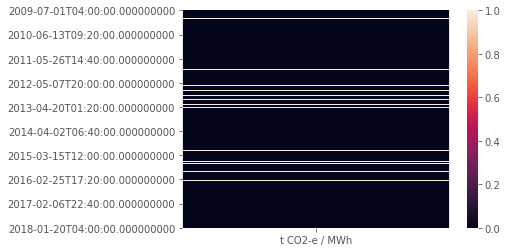

In [20]:
#dark shades indicate the presence of values
#white bars indicate the presence of NaNs
plt.style.use('ggplot')

fig = sns.heatmap(df_new.isna(), yticklabels=100000)

### __Data imputation of time series__

Due to the nature of time series data, the imputation of missing values needs extra attention. The potential presence of time series trends and seasonality renders imputations using e.g. mean or median deduced from the entire dataset little useful. Instead, any imputation should rather consider the local value range around a NaN value. In the following, we will see one approach of how that works.

<img src="../images/time_series_imputation.jpg"> <br/>
source: https://www.hindawi.com/journals/mpe/2010/513810/fig9/

In [21]:
#we use the .rolling method to calculate the rolling mean composed of always 30 subsequent values
#the .assign method adds a new column with our rolling mean to df_new, all of which we save in df_impute

df_impute = df_new.assign(rolling_mean=df_new['t CO2-e / MWh'].rolling(window=30, min_periods=1).mean())

In [22]:
df_impute.head()

,t CO2-e / MWh,rolling_mean
2009-07-01 04:00:00,0.991217,0.991217
2009-07-01 04:05:00,0.000000,0.495609
2009-07-01 04:10:00,0.000000,0.330406
2009-07-01 04:15:00,0.991217,0.495609
2009-07-01 04:20:00,1.025701,0.601627


In [23]:
df_impute.isna().any()

t CO2-e / MWh     True
rolling_mean     False
dtype: bool

In [24]:
#here we use the numpy.where() method to replace only NaNs with values from the rolling_mean column
df_impute['t CO2-e / MWh'] = np.where(df_impute['t CO2-e / MWh'].isnull(),\
                                  df_impute['rolling_mean'], df_impute['t CO2-e / MWh'])

df_impute.drop(columns='rolling_mean', inplace=True)

In [25]:
#let's see if everything worked
df_impute.isna().any()

t CO2-e / MWh    False
dtype: bool

In [27]:
pd.set_option('display.max_rows', None)
df_impute[df_impute['t CO2-e / MWh'].isna()].iloc[:102,]

,t CO2-e / MWh


In [29]:
df_impute.to_pickle('../data/train_clean.pkl')